In [1]:
%load_ext autoreload
%config Completer.use_jedi = False

In [2]:
%autoreload 2
import FEMOL
import numpy as np
np.set_printoptions(linewidth=200)
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt


# Topology optimization for the fundamental frequency of a vibrating structure

## 1. Example problem definition

In [79]:
mesh = FEMOL.mesh.rectangle_Q4(20, 20, 15, 15)

problem = FEMOL.FEM_Problem(mesh=mesh, physics='modal', model='plane')
material1 = FEMOL.materials.isotropic_bending_benchmark()
problem.define_materials(material1)
problem.define_tensors(1)  # thick=1

problem.add_fixed_domain(FEMOL.domains.inside_box([0], [[0, 15]]), ddls=[0, 1])

#problem.add_forces(force=[0, 0, -1, 0, 0, 0], domain=FEMOL.domains.inside_box([[9,11]], [[9,11]]))

w, v = problem.solve(filtre=0)


solving using scipy
solved in :  0.18677115440368652  s


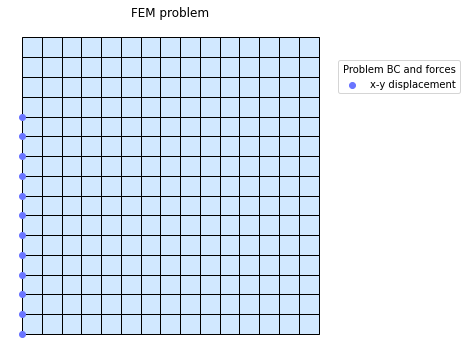

In [84]:
problem.plot()

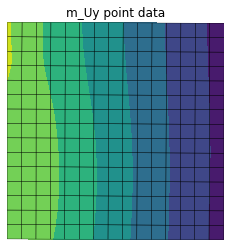

In [85]:
mesh.add_mode('m', v[24], 2)
mesh.plot.point_data('m_Uy')
reference_vector = v[0]  # Save for MAC Analysis

## 2. The optimization problem formulation

### Optimization problem constraints

maximize : $\; min\; (\omega_j^2) \;\; j = 1,...,J $

with : $\; \rho_1, ..., \rho_{N_E}$ The individual element densities of the problem

and : $j = 1,...,J$ The vibration modes of the structure

Subject to :

The eigenvalue theorem : 

$ K \phi_j = \omega_j^2 M \phi_j \; \; j = 1, ..., J$

The orthogonality criteria :

$ \phi_j^T M \phi_k = \delta_{jk}, \; \; j \geq k, \;\; kj = 1,...,J$

Where : $\delta_{jk} = 1$ if $i=k$ and $0$ if $j \neq k$

The Volume constraint :

$\sum_{e=1}^{N_e} \; \rho_e V_e - V^* \leq 0$ and $V^* = \alpha V_0$

Where : $\alpha$ is the volume fraction constraint and $V_0$ is the domain volume

And the admissible density values :

$0 < \rho_{min} \leq \rho_e \leq 1$ for $e = 1, ..., N_e$

Here, $\rho_{min}$ represents the admissible lower bound to the element density (typically $10^{-3}$)

### Sensitivity Analysis

The sensibility of the eigenvalue is given by $\frac{\partial \lambda_j}{\partial \rho_e}$ where $\lambda_j = \omega_j^2$ is obtained by differentiating the eigenvalue theorem with respect to $\rho_e$ :



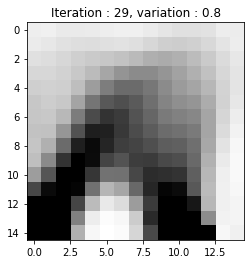

In [86]:
SIMP = FEMOL.SIMP_VIBE(problem, objective='max eig')
mesh = SIMP.solve(v[24])

In [93]:
"""
Test the SIMP Compliance minimization for an unordered mesh
"""
mesh = FEMOL.mesh.circle_Q4(1, 10)
problem = FEMOL.FEM_Problem(mesh=mesh, physics='displacement', model='plane')
composite_material = FEMOL.materials.general_carbon()
plies = [0, 45, -45, -45, 45, 0]  # total plies
layup = FEMOL.laminate.Layup(composite_material, plies=plies, symetric=False)

# define the material and tensors the stiffness tensors are computed from the layup
problem.define_materials(composite_material)
problem.define_tensors(layup)

# Fix all the degrees of freedom
problem.add_fixed_domain(FEMOL.domains.outside_circle(0, 0, np.abs(mesh.points.max()) - 0.01))

# Create a force domain at the center
force_domain = FEMOL.domains.inside_box([[-0.09, 0.09]], [[-0.09, 0.09]])
Fx = -1e3  # F = -10 kN
F = [Fx, 0]  # F = [Fx, Fy]
problem.add_forces(F, force_domain)

SIMP = FEMOL.SIMP_COMP(problem)
mesh = SIMP.solve(converge=0.03, max_iter=3, plot=False, save=False)
X = np.array(list(mesh.cell_data['X'].values())).flatten()

Iteration : 3, variation : 25.2


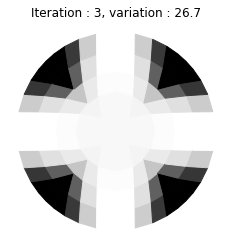

True

In [252]:
mesh = FEMOL.mesh.circle_Q4(1, 10)
problem = FEMOL.FEM_Problem(mesh=mesh, physics='displacement', model='plate')
material1 = FEMOL.materials.IsotropicMaterial(E=3e6, mu=0.3, rho=5000)
material2 = FEMOL.materials.general_flax()
layup_coat = FEMOL.laminate.Layup(material=material2, plies=[0, 0, 0, 0])
problem.define_materials(material1, material2)
problem.define_tensors(0.1, layup_coat)
problem.add_fixed_domain(FEMOL.domains.outside_circle(0, 0, 0.9))
problem.add_forces([0, 0, -1e5, 0, 0, 0], FEMOL.domains.inside_circle(0, 0, 0.25))
SIMP = FEMOL.SIMP_COMP(problem, volfrac=0.4)
mesh = SIMP.solve(max_iter=3, plot=True, save=False)
c1 = np.abs(np.sum(mesh.point_data['d1_Uz']))
c2 = np.abs(np.sum(mesh.point_data['d3_Uz']))
c2 < c1

In [251]:
c2<c1

True

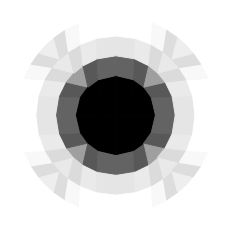

In [243]:
mesh.plot.cell_data('X')

In [237]:
c2

0.045202006822785114

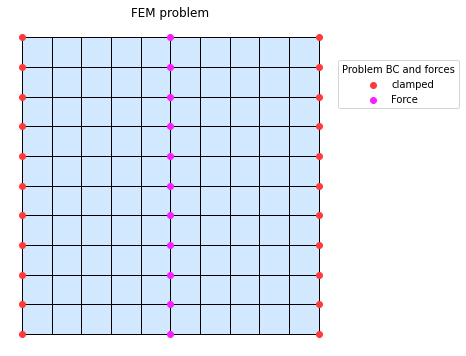

In [231]:
problem.plot()

In [190]:
np.abs(np.sum(mesh.point_data['d3_Uz']))

435.83566210318696